# Snow Depth - ICESat-2 Applications Tutorial

```{admonition} Learning Objectives
**This is a placeholder Notebook for the snow depth tutorial**
- gain experience in working with SlideRule to access and pre-process ICESat-2 data
- learn how use projections and interpolation to compare ICESat-2 track data with gridded raster products
- develop a general understanding of how to measure snow depths with LiDAR, and learn about opportunities and challenges when using ICEsat-2 along-track products
```

## Computing environment

We'll be using the following open source Python libraries in this notebook:

In [48]:
import ipyleaflet
from ipyleaflet import Map, Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

import ipywidgets
import datetime
import re

# maybe the ones below??
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import CRS, Proj, transform, Transformer
from sliderule import sliderule, icesat2, earthdata, h5
from scipy.interpolate import RectBivariateSpline

## Draft outline:

Background:
- How do we measure snow depth with lidar
- How do we measure snow depth with ICESat-2 specifically
- What challenges do we need to think about
    - Comparing a raster to an IS-2 transect
    - Geolocation
    - Vegetation, slope affects
- What do we need
    - A region of interest
    - ICESat-2 data
    - A snow-free reference DEM
        
Define ROI:
- Define bounding box
- Plot box over satellite image? Map showing location of ROI?
    
Calculate ATL06:
- Talk a little about why were using ALT06 (presuming we decide to use ATL06)
- Set Parameters
    - Talk a little about the parameters, provide link to more detailed info from SlideRule website
- Show code cell to calculate ICESat-2 data for demonstration
- Read in previously calculated data
- Plot ICESat-2 tracks on ROI, height colorbar?
    
Pull DEM:
- Talk about raster data?
- Show code cell to pull 3DEP data for demonstration purposes
- Read in previously downloaded DEM
- Plot
    
Compare IS-2 and DEM:
	- Remind audience that we need to process the raster data to be comparable to a point transect
	- Integrate DEM (mention that there are a number of ways to do this, we are showing a simple way for time)
	- Plot snow depths

## Data

Use SlideRule to acquire ATL06 data as well as the gridded data, noting customization for averaging footprint, photon identification: this will be a modified ATL06 download that includes some vegetation filtering


**Data considerations:**

pre-download the demonstration files to the CryoHub checking in on maximum file size - try to keep the region of interest relatively small for the tutorial? @zachghiaccio to contact CryoHub folks
checking to see if SlideRule can be used to acquire the gridded DEM @KarinaZikan.

To obtain snow depth with ICESat-2, we are going to use SlideRule for its high level of customization. We are going to look at snow depth data over the Arctic Coastal Plain (ACP) of Alaska, which is a relatively flat region with little vegetation. Thus, we should expect good agreement between ICESat-2 and our lidar rasters of interest.

After we initialize SlideRule, we define our region of interest. Notice that there are two options in the cell below. This is because SlideRule accepts either the coordinates of a box/polygon or a geoJSON for the `region` input. 

We are going to use the `sliderule.icesat2.toregion()` function in this tutorial using a pre-generated polygon, but we have the secondary method included for your personal reference.

In [2]:
# Initialize SlideRule
icesat2.init("slideruleearth.io")

In [11]:
# Define region of interest over ACP, Alaska
region = [ {"lon":-148.85, "lat": 69.985},
           {"lon":-148.527, "lat": 69.985},
           {"lon":-148.527, "lat": 70.111},
           {"lon":-148.85, "lat": 70.111},
           {"lon":-148.85, "lat": 69.985} ]

# Alternate method, with geoJSON [TO BE ADDED]
path = '/home/jovyan/ICESat-2-Hackweek-2023/book/tutorials/applications-snow-depth/supplemental-data/'
region = sliderule.toregion(f'{path}acp_lidar_box.geojson')["poly"]

Now we are going to build our SlideRule request with a few more parameters. 

**Review**: In the below cell, what does each parameter represent?

**Keep this cell hidden until activity is over**

We defined our `region` above, so let's run through the remaining parameters:
* `srt`: Only land photons will be considered.
* `cnf`: Only high-confidence photons.
* `atl08_class`: Only ground photons, as identified by the ATL08 algorithm.
* `ats`: The maximum along-track spread (uncertainty) in aggregated photons will be 5 m.
* `len`: The length of each segment of aggregated photons will be 20 m.
* `res`: The along-track resolution will be 10 m. Because each segment will be 20 m long, there will be overlap between successive data points.
* `maxi`: The SlideRule refinement algorithm will iterate 5 times per segment at maximum.

In [12]:
# Build SlideRule request
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "atl08_class": ["atl08_ground"],
    "ats": 5.0,
    "len": 20.0,
    "res": 10.0,
    "maxi": 5
}

is2_df = icesat2.atl06p(parms, "nsidc-s3")

is2_df.head()

,n_fit_photons,gt,distance,pflags,dh_fit_dy,spot,dh_fit_dx,w_surface_window_final,h_sigma,rms_misfit,cycle,h_mean,rgt,segment_id,geometry
time,,,,,,,,,,,,,,,
2018-11-10 12:34:28.892227584,10,20,1.226097e+07,0,0.0,5,-0.020650,3.0,0.082734,0.261562,1,42.515685,655,612118,POINT (-148.79276 70.01618)
2018-12-12 22:17:07.551062272,54,50,7.807696e+06,0,0.0,2,-0.002470,3.0,0.015306,0.111972,1,43.945144,1150,389532,POINT (-148.67702 70.00233)
2018-12-12 22:17:07.552469760,54,50,7.807706e+06,0,0.0,2,-0.001858,3.0,0.014800,0.107915,1,43.911763,1150,389533,POINT (-148.67706 70.00242)
2018-12-12 22:17:07.553876480,50,50,7.807716e+06,0,0.0,2,-0.004367,3.0,0.016673,0.117839,1,43.879276,1150,389533,POINT (-148.67709 70.00251)
2018-12-12 22:17:07.555285760,49,50,7.807726e+06,0,0.0,2,-0.008977,3.0,0.021947,0.152915,1,43.814805,1150,389534,POINT (-148.67712 70.00260)


You probably noticed that the algorithm took a long time to generate the GeoDataFrame. That is because (i) our region of interest was rather large and (ii) we obtained all ICESat-2 tracks in the ROI since its launch (2018).

Just for the sake of interest, let's take a look at all of the ICESat-2 tracks over ACP, Alaska.

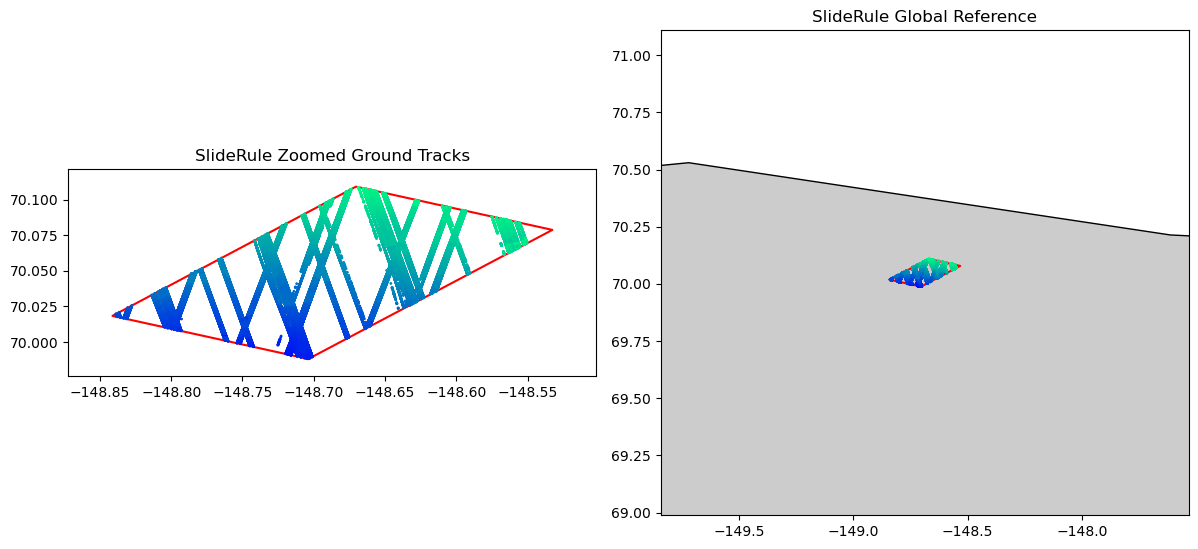

In [13]:
# Sample plot for all of the ICESat-2 tracks since its launch

# Calculate Extent
lons = [p["lon"] for p in region]
lats = [p["lat"] for p in region]
lon_margin = (max(lons) - min(lons)) * 0.1
lat_margin = (max(lats) - min(lats)) * 0.1

# Create Plot
fig,(ax1,ax2) = plt.subplots(num=None, ncols=2, figsize=(12, 6))
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]

# Plot SlideRule Ground Tracks
ax1.set_title("SlideRule Zoomed Ground Tracks")
is2_df.plot(ax=ax1, column=is2_df["h_mean"], cmap='winter_r', s=1.0, zorder=3)
ax1.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2)
ax1.set_xlim(min(lons) - lon_margin, max(lons) + lon_margin)
ax1.set_ylim(min(lats) - lat_margin, max(lats) + lat_margin)
ax1.set_aspect('equal', adjustable='box')

# Plot SlideRule Global View
ax2.set_title("SlideRule Global Reference")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax2, color='0.8', edgecolor='black')
is2_df.plot(ax=ax2, column=is2_df["h_mean"], cmap='winter_r', s=1.0, zorder=3)
ax2.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2)
ax2.set_xlim(min(lons)-1, max(lons)+1)
ax2.set_ylim(min(lats)-1, max(lats)+1)
ax2.set_aspect('equal', adjustable='box')

# Show Plot
plt.tight_layout()

It is cool to see all of the available data, but we only have lidar DEMs available from March 2022. So, we are going to subset the data to include one ICESat-2 track (**RGT 1097**) in **March 2022**.

In [14]:
# Subset ICESat-2 data to single RGT, time of year
is2_df_subset = is2_df[is2_df['rgt']==1097]
is2_df_subset = is2_df_subset.loc['2022-03']

is2_df_subset.head()

,n_fit_photons,gt,distance,pflags,dh_fit_dy,spot,dh_fit_dx,w_surface_window_final,h_sigma,rms_misfit,cycle,h_mean,rgt,segment_id,geometry
time,,,,,,,,,,,,,,,
2022-03-04 02:48:03.241118976,199,50,1.225157e+07,0,0.0,5,0.000780,3.0,0.009799,0.138202,14,25.018173,1097,611652,POINT (-148.67388 70.10714)
2022-03-04 02:48:03.242518016,195,50,1.225158e+07,0,0.0,5,0.002869,3.0,0.010362,0.144591,14,25.020354,1097,611653,POINT (-148.67391 70.10705)
2022-03-04 02:48:03.243916288,184,50,1.225159e+07,0,0.0,5,0.000026,3.0,0.011391,0.154393,14,25.041014,1097,611653,POINT (-148.67395 70.10696)
2022-03-04 02:48:03.245315328,179,50,1.225160e+07,0,0.0,5,0.002708,3.0,0.011574,0.154308,14,25.073477,1097,611654,POINT (-148.67398 70.10687)
2022-03-04 02:48:03.246711808,199,50,1.225161e+07,0,0.0,5,0.006243,3.0,0.010433,0.146489,14,25.123777,1097,611654,POINT (-148.67401 70.10678)


## sample the DTM to ICESat-2 ground track 
mention importance of geolocation errors and choice of interpolation

Our ICESat-2 data is ready to go! Now it's time to load the airborne lidar data, and co-register it with ICESat-2.

The lidar data we will use is from the University of Alaska, Fairbanks (UAF). The UAF lidar obtains snow-on and snow-off DEMs/DTMs with a 1064 nm (near-infrared) laser, from which it can also derive snow depth. 

UAF lidar rasters normally have a spatial resolution of 0.5 m, which would take a long time to process for this tutorial. As a compromise between computation speed and resolution, we will use rasters that have been coarsened to 3 m resolution.

The best way to load lidar DEMs/DTMs is to use `rioxarray`:

In [17]:
# File paths for UAF rasters
f_snow_off = f'{path}coastalplain_2022aug31_dtm_3m.tif'
f_snow_on = f'{path}coastalplain_2022mar12_snowdepth_3m.tif'

# Load files as rioxarray datasets
lidar_snow_off = rioxarray.open_rasterio(f_snow_off)
lidar_snow_on = rioxarray.open_rasterio(f_snow_on)

It is not immediately obvious, but the UAF rasters are in a different spatial projection than ICESat-2. UAF is in **EPSG:32606**, ICESat-2 is in **WGS84/EPSG:4326**.

In order to directly compare these two datasets, we are going to add reprojected coordinates to the ICESat-2 DataFrame. In essence, we will go from **latitude/longitude** to **northing/easting**. Luckily, there is an easy way to do this with GeoPandas, specifically the `geopandas.to_crs()` function.

In [19]:
# Initialize ICESat-2 coordinate projection
is2_df_subset = is2_df_subset.set_crs("EPSG:4326")

# Change to EPSG:32606
is2_df_subset = is2_df_subset.to_crs("EPSG:32606")

is2_df_subset.head()

,n_fit_photons,gt,distance,pflags,dh_fit_dy,spot,dh_fit_dx,w_surface_window_final,h_sigma,rms_misfit,cycle,h_mean,rgt,segment_id,geometry
time,,,,,,,,,,,,,,,
2022-03-04 02:48:03.241118976,199,50,1.225157e+07,0,0.0,5,0.000780,3.0,0.009799,0.138202,14,25.018173,1097,611652,POINT (436440.828 7778693.972)
2022-03-04 02:48:03.242518016,195,50,1.225158e+07,0,0.0,5,0.002869,3.0,0.010362,0.144591,14,25.020354,1097,611653,POINT (436439.341 7778684.087)
2022-03-04 02:48:03.243916288,184,50,1.225159e+07,0,0.0,5,0.000026,3.0,0.011391,0.154393,14,25.041014,1097,611653,POINT (436437.853 7778674.203)
2022-03-04 02:48:03.245315328,179,50,1.225160e+07,0,0.0,5,0.002708,3.0,0.011574,0.154308,14,25.073477,1097,611654,POINT (436436.363 7778664.305)
2022-03-04 02:48:03.246711808,199,50,1.225161e+07,0,0.0,5,0.006243,3.0,0.010433,0.146489,14,25.123777,1097,611654,POINT (436434.874 7778654.421)


Now, we are going to co-register both rasters to the queried ICESat-2 data. The function below is fairly long, but the gist is that we are using a spline interpolant to match both the snow-off UAF data (surface height) and UAF snow depths with ICESat-2 surface heights. The resulting DataFrame will have both ICESat-2 and UAF data in it.

In [49]:
def coregister_is2(lidar_snow_off, lidar_snow_depth, is2_df):
    """
    Co-registers UAF data with ICESat-2 data with a rectangular bivariate
    spline.

    Parameters
    ----------
    lidar_height : rioxarray dataset
        Lidar DEM/DTM in rioarray format.
    lidar_snow_depth : rioxarray dataset
        Lidar-derived snow depth in rioxarray format.
    is2_df : GeoDataFrame
        GeoDataFrame for the ICESat-2 data generated with SlideRule.

    Returns
    -------
    is2_uaf_df : GeoDataFrame
        Contains the coordinate and elevation data that matches best with
        ICESat-2.

    """
    
    # Define x/y coordinates from snow-off data
    x0 = np.array(lidar_snow_off.x)
    y0 = np.array(lidar_snow_off.y)
    
    # Do the same, but for snow depth data
    xs = np.array(lidar_snow_on.x)
    ys = np.array(lidar_snow_on.y)
    
    # Filter NaNs that would otherwise mess up the interpolators
    dem_heights = np.array(lidar_snow_off.sel(band=1))[::-1,:]
    dem_heights[np.isnan(dem_heights)] = -9999
    dem_depths = np.array(lidar_snow_depth.sel(band=1))[::-1,:]
    dem_depths[np.isnan(dem_depths)] = -9999
    
    # Generate interpolators
    interp_height = RectBivariateSpline(np.array(y0)[::-1], 
                                       np.array(x0),
                                       dem_heights)
    interp_depth = RectBivariateSpline(np.array(ys)[::-1],
                                       np.array(x0),
                                       dem_depths)
    
    # Use constructed interpolators to align UAF with ICESat-2. This aligns with all six
    # ICESat-2 beams
    is2_uaf_df = pd.DataFrame()
    for beam in np.unique(is2_df['gt']):
        is2_tmp = is2_df.loc[is2_df['gt']==beam]
            
        # ICESat-2 x/y coordinates
        xn = is2_tmp.geometry.x
        yn = is2_tmp.geometry.y
            
        # Define indices within x/y bounds of DEM
        i1 = (xn>np.min(x0)) & (xn<np.max(x0))
        i1 &= (yn>np.min(y0)) & (yn<np.max(y0))
        
        lidar_height = interp_height(yn[i1], xn[i1], grid=False)
        lidar_snow_depth = interp_depth(yn[i1], xn[i1], grid=False)
        # Set x/y coordinates, UAF height/snow depth, and ICESat-2 heights into same DataFrame
        tmp = gpd.GeoDataFrame(data={'x': xn[i1],
                                     'y': yn[i1],
                                     'time': is2_tmp.index.values[i1],
                                     'beam': is2_tmp['gt'][i1],
                                     'lidar_height': lidar_height,
                                     'lidar_snow_depth': lidar_snow_depth,
                                     'is2_height': is2_tmp['h_mean'][i1],
                                     'h_sigma': is2_tmp['h_sigma'][i1],
                                     'dh_fit_dx': is2_tmp['dh_fit_dx'][i1]})
        
        # Concatenate coregistered data to DataFrame
        is2_uaf_df = pd.concat([is2_uaf_df, tmp])
        
        # Add latitude/longitude coordinates to new DataFrame
        transformer = Transformer.from_crs("EPSG:32606", "EPSG:4326", always_xy=True)
        is2_uaf_df['lon'], is2_uaf_df['lat'] = transformer.transform(is2_uaf_df['x'],
                                                                     is2_uaf_df['y'])
        
    return is2_uaf_df
                                     

In [50]:
# Co-register ICESat-2 and UAF using the above function
is2_uaf_df = coregister_is2(lidar_snow_off, lidar_snow_on, is2_df_subset)

# Convert to a GeoDataFrame
geom = gpd.points_from_xy(is2_uaf_df.lon, is2_uaf_df.lat)
is2_uaf_gpd = gpd.GeoDataFrame(is2_uaf_df,
                               geometry=geom, 
                               crs="EPSG:4326")

is2_uaf_gpd.head()

,x,y,time,beam,lidar_height,lidar_snow_depth,is2_height,h_sigma,dh_fit_dx,lon,lat,geometry
time,,,,,,,,,,,,
2022-03-04 02:48:03.440237056,439452.923543,7.776921e+06,2022-03-04 02:48:03.440237056,30,26.683965,0.457813,27.205629,0.010734,0.001480,-148.593376,70.091971,POINT (-148.59338 70.09197)
2022-03-04 02:48:03.441652480,439451.375043,7.776911e+06,2022-03-04 02:48:03.441652480,30,26.696361,0.423185,27.192147,0.010345,-0.004178,-148.593410,70.091882,POINT (-148.59341 70.09188)
2022-03-04 02:48:03.443069952,439449.823397,7.776901e+06,2022-03-04 02:48:03.443069952,30,26.718985,0.515149,27.234907,0.011003,0.011683,-148.593444,70.091794,POINT (-148.59344 70.09179)
2022-03-04 02:48:03.444484352,439448.267944,7.776892e+06,2022-03-04 02:48:03.444484352,30,26.713260,0.620624,27.337950,0.010929,0.009041,-148.593478,70.091705,POINT (-148.59348 70.09170)
2022-03-04 02:48:03.445898752,439446.713865,7.776882e+06,2022-03-04 02:48:03.445898752,30,26.739161,0.638703,27.389371,0.011256,0.004028,-148.593512,70.091616,POINT (-148.59351 70.09162)


As you can see, we now have a DataFrame that includes several useful variables:
* `beam`: ICESat-2 beam (gt1l, gt2l, etc.)
* `lidar_height`: Snow-off surface height from UAF lidar.
* `lidar_snow_depth`: Snow depth derived from UAF.
* `is2_height`: ICESat-2 surface height (snow-on, in this case).
* `h_sigma`: ICESat-2 height uncertainty.
* `dh_fit_dx`: Along-track slope of the terrain.

With this DataFrame, it will now be very simple to derive snow depth!

## differencing to get a snowdepth


To derive snow depth with ICESat-2, we need a snow-off DEM and ICESat-2 observations over a snow-covered surface. The variable `lidar_height` in our DataFrame is the snow-off DEM co-registered with ICESat-2, and we subsetted our SlideRule data to specifically look at ACP during snow-on conditions.

Thus, deriving snow depth is now as simple as taking the difference between `is2_height` and `lidar_height`:

In [51]:
# Derive snow depth using snow-on/snow-off differencing
is2_uaf_gpd['is2_snow_depth'] = is2_uaf_gpd['is2_height'] - is2_uaf_gpd['lidar_height']

# Estimate the difference (bias) between IS-2 depths and UAF depths
is2_uaf_gpd['snow_depth_residual'] = is2_uaf_gpd['is2_snow_depth'] - is2_uaf_gpd['lidar_snow_depth']

## visualize the result

Horray, we finally have snow ICESat-2 snow depths! Let's make a couple of plots with the data we have.

Text(105.34722222222221, 0.5, 'Latitude')

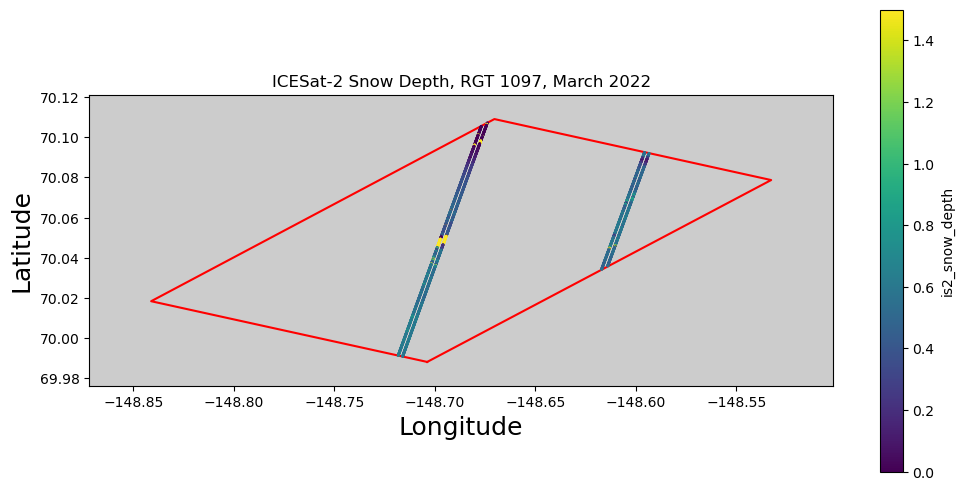

In [61]:
## Map Plot
# Define plot margins
#lidar_lons = [-148.67, -148.53, -148.70, -148.84, -184.67]
#lidar_lats = [70.11, 70.08, 69.99, 70.02, 70.11]
#lon_margin = (max(lons) - min(lons)) * 0.1
#lat_margin = (max(lats) - min(lats)) * 0.1

# Create Plot
fig,ax = plt.subplots(num=None, figsize=(12, 6))

# Plot SlideRule Ground Tracks
ax.set_title("ICESat-2 Snow Depth, RGT 1097, March 2022")
is2_uaf_gpd.plot.scatter(ax=ax, x='lon', y='lat', c='is2_snow_depth',
                             s=1.0, zorder=3, vmin=0, vmax=1.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='0.8', edgecolor='black')
ax.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2)
ax.set_xlim(min(lons) - lon_margin, max(lons) + lon_margin)
ax.set_ylim(min(lats) - lat_margin, max(lats) + lat_margin)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)

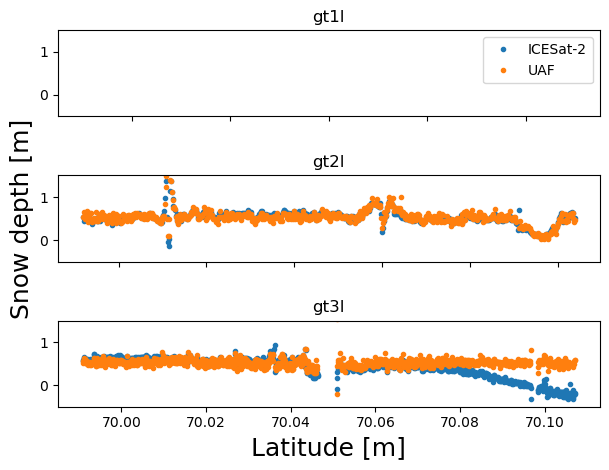

In [71]:
## Along-track snow depth comparison
# Plot snow depths for the three strong beams
fig, (ax1,ax2,ax3) = plt.subplots(3)

# Left strong beam
tmp_df = is2_uaf_gpd[is2_uaf_gpd['beam']==10]
ax1.plot(tmp_df['lat'], tmp_df['is2_snow_depth'], '.', label='ICESat-2')
ax1.plot(tmp_df['lat'], tmp_df['lidar_snow_depth'], '.', label='UAF')
ax1.set_title('gt1l')
ax1.legend()

# Central strong beam
tmp_df = is2_uaf_gpd[is2_uaf_gpd['beam']==30]
ax2.plot(tmp_df['lat'], tmp_df['is2_snow_depth'], '.')
ax2.plot(tmp_df['lat'], tmp_df['lidar_snow_depth'], '.')
ax2.set_ylabel('Snow depth [m]', fontsize=18)
ax2.set_title('gt2l')

# Right strong beam
tmp_df = is2_uaf_gpd[is2_uaf_gpd['beam']==50]
ax3.plot(tmp_df['lat'], tmp_df['is2_snow_depth'], '.')
ax3.plot(tmp_df['lat'], tmp_df['lidar_snow_depth'], '.')
ax3.set_xlabel('Latitude [m]', fontsize=18)
ax3.set_title('gt3l')
plt.tight_layout()

# Only include outer axis labels
for axs in [ax1, ax2, ax3]:
    axs.label_outer()
    axs.set_ylim([-0.5, 1.5])

**Question for everyone**: There's nothing plotted for the left strong beam! Why is that? (hint: look at the map figure)

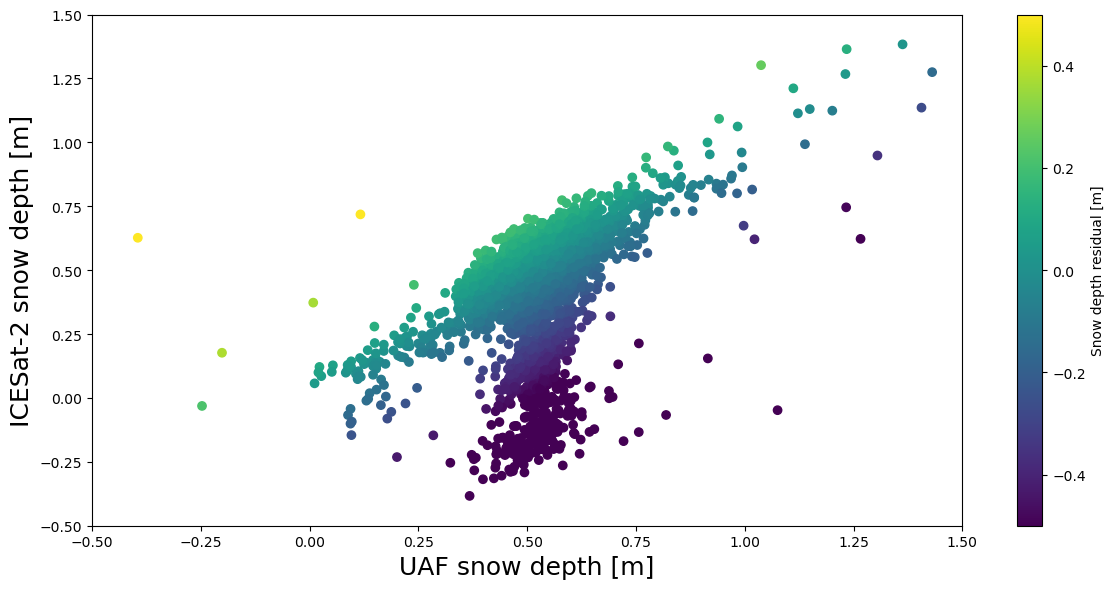

In [82]:
## Scatter plot of ICESat-2 depths vs. UAF depths
fig, ax = plt.subplots(figsize=(12,6))
s = ax.scatter(is2_uaf_gpd['lidar_snow_depth'], is2_uaf_gpd['is2_snow_depth'],
               c=is2_uaf_gpd['snow_depth_residual'], vmin=-0.5, vmax=0.5)
ax.set_xlabel('UAF snow depth [m]', fontsize=18)
ax.set_ylabel('ICESat-2 snow depth [m]', fontsize=18)
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-0.5, 1.5])
cbar = fig.colorbar(s, ax=ax)
cbar.set_label('Snow depth residual [m]')
plt.tight_layout()

It's not perfect thanks to a few oddities in gt3l, but otherwise the scatter plot looks great!

## Interactive visualization

The ipyleaflet library allows us to create interactive map visualizations. Below we define a geographic bounding box for our area of interest, and plot it on an interactive "slippy map".

In [ ]:
bbox = [-108.3, 39.2, -107.8, 38.8]
west, north, east, south = bbox
bbox_ctr = [0.5*(north+south), 0.5*(west+east)]

Display the bounding box on an interactive basemap for context. All the available basemaps can be found in the [ipyleaflet documentation](https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html)

In [ ]:
m = Map(center=bbox_ctr, zoom=10)
rectangle = Rectangle(bounds=((south, west), (north, east))) #SW and NE corners of the rectangle (lat, lon)
m.add_layer(rectangle)
m

### NASA GIBS basemap

NASA's [Global Imagery Browse Services (GIBS)](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/gibs) is a great Web Map Tile Service (WMTS) to visualize NASA data as pre-rendered tiled raster images. The NASA [Worldview](https://worldview.earthdata.nasa.gov) web application is a way to explore all GIBS datasets. We can also use ipyleaflet to explore GIBS datasets, like MODIS truecolor images, within a Jupyter Notebook. Use the slider in the image below to reveal the image from 2019-04-25:

In [ ]:
m = Map(center=bbox_ctr, zoom=6)

right_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2019-04-25")
left_layer = TileLayer()
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
m.add_control(control)

m.add_layer(rectangle)

m

### Exercise 1

Re-create the map above using different tile layers for both the right and left columns. Label a single point of interest with a marker, such as the city of Grand Junction, Colorado.

In [ ]:
# Add your solution for exercise 1 here!

## Summary

 🎉 Congratulations! You've completely this tutorial and have seen how we can add  notebook can be formatted, and how to create interactive map visualization with ipyleaflet.
 

```{note}
You may have noticed Jupyter Book adds some extra formatting features that do not necessarily render as you might expect when *executing* a noteook in Jupyter Lab. This "admonition" note is one such example.
```

:::{warning}
Jupyter Book is very particular about [Markdown header ordering](https://jupyterbook.org/structure/sections-headers.html?highlight=headers#how-headers-and-sections-map-onto-to-book-structure) to automatically create table of contents on the website. In this tutorial we are careful to use a single main header (#) and sequential subheaders (#, ##, ###, etc.)
:::

## References

To further explore the topics of this tutorial see the following detailed documentation:

* [Jupyter Book rendering of .ipynb notebooks](https://jupyterbook.org/file-types/notebooks.html)
* [Jupyter Book guide on writing narrative content](https://jupyterbook.org/content/index.html)
* [ipyleaflet documentation](https://ipyleaflet.readthedocs.io)